### Add scraped data into dataframe

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import sqlalchemy
import config

from sqlalchemy.exc import ResourceClosedError

In [2]:
from db import db, query, query_list
df1 = query('SELECT * FROM  beers')
# df = df.drop(columns='grouping')

In [3]:
from db import db, query, query_list
df_bars = query('SELECT * FROM  bars')


In [4]:
# make a copy of dataframe
df = df1.copy()

In [7]:
df.sample(2)

,name,beer_url,beer_type,abv,size,kind,price,bar_url,address,grouping,origin
50277,Ginga Kogen,https://www.beermenus.com/beers/10565-ginga-kogen,German Hefeweizen,5.0%,10oz,Bottle,3.99,https://www.beermenus.com/places/20398-joe-can...,"799 Route 46, Parsippany-Troy Hills, NJ 07054",BOTTLES,None
55554,Evil Twin Imperial Biscotti Break,https://www.beermenus.com/beers/16433-evil-twi...,Imperial Stout,11.5%,16oz,4 Pack Cans,12.99,https://www.beermenus.com/places/31763-verona-...,"360 Bloomfield Avenue, Verona, NJ 07044",CANS,"Brooklyn, NY"


In [6]:
df_bars.sample(2)


,establishment_type,neighborhood,city,bar_name,bar_url
360,Beer Store,Upper West Side,"Manhattan, NY",Beer Shop NYC,https://www.beermenus.com/places/28665-beer-sh...
38,Restaurant,None,None,Fulton Hall,https://www.beermenus.com/places/55758-fulton-...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56340 entries, 0 to 56339
Data columns (total 11 columns):
name         56340 non-null object
beer_url     55947 non-null object
beer_type    55586 non-null object
abv          55586 non-null object
size         54555 non-null object
kind         55780 non-null object
price        54101 non-null object
bar_url      56340 non-null object
address      56340 non-null object
grouping     56340 non-null object
origin       53979 non-null object
dtypes: object(11)
memory usage: 4.7+ MB


In [9]:
df_bars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 5 columns):
establishment_type    540 non-null object
neighborhood          186 non-null object
city                  478 non-null object
bar_name              590 non-null object
bar_url               590 non-null object
dtypes: object(5)
memory usage: 23.1+ KB


In [10]:
# total number of records
n = df.shape[0]
n

56340

In [11]:
# how many values are we missing per category

null_count_list = []
for i in df.columns:
    null_count_list.append(n-df.count()[i])

null_values = zip(df.columns, null_count_list)
missing_list_prefilter = list(null_values)[1:]
missing_list_prefilter

[('beer_url', 393),
 ('beer_type', 754),
 ('abv', 754),
 ('size', 1785),
 ('kind', 560),
 ('price', 2239),
 ('bar_url', 0),
 ('address', 0),
 ('grouping', 0),
 ('origin', 2361)]

In [12]:
df.sample(2)

,name,beer_url,beer_type,abv,size,kind,price,bar_url,address,grouping,origin
24659,Funkwerks Raspberry Provincial,https://www.beermenus.com/beers/51006-funkwerk...,Sour Ale,4.2%,12oz,Draft,7,https://www.beermenus.com/places/18283-coals-p...,"131 Parkway Road, Bronxville, NY 10708",ON TAP,"Fort Collins, CO"
48516,Bolero Snort Anudder Day In Paradise,https://www.beermenus.com/beers/330123-bolero-...,NE/Hazy IPA,6.0%,16oz,4 Pack Cans,16.99,https://www.beermenus.com/places/19535-bay-sho...,"51 Garfield Street, Bay Shore, NY 11706",CANS,"Ridgefield Park, NJ"


### Attempt to clean df

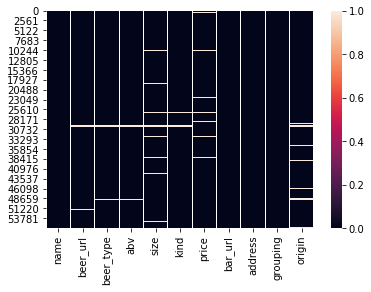

In [13]:
sns.heatmap(df.isna())

In [ ]:
# check
print(df.loc[770]['size'], type(df.loc[770]['size']))

In [14]:
# Fill NONE values in size
df['size'] = df['size'].fillna(value='16oz')

In [15]:
# check if it worked
print(df.loc[770]['size'], type(df.loc[770]['size']))

16oz <class 'str'>


#### Filter null values

In [16]:
# how many records have no price OR have no beer_type OR have no size info given
(df1.loc[df1['price'].isnull()].shape[0]+\
df1.loc[df1['beer_type'].isnull()].shape[0]+\
df1.loc[df1['size'].isnull()].shape[0])/n

0.084806531771388

In [ ]:
# filter records missing beer_type, size, or price since these are variables of interest
df = df[df['beer_type'].notnull()]
df = df[df['size'].notnull()]
df = df[df['price'].notnull()]

In [ ]:
# check if filtering worked
(df.loc[df['price'].isnull()].shape[0]+\
df.loc[df['beer_type'].isnull()].shape[0]+\
df.loc[df['size'].isnull()].shape[0])/n

#### Filter odd volume units (kegs, mL, etc.)

In [ ]:
# check to see if following cell works
df.loc[df['size']=='33cl']

In [17]:
# how many records have unusable volume unit
(df1.loc[df1['size'].str.contains("Keg")].shape[0]+\
df1.loc[df1['size'].str.contains("cl")].shape[0]+\
df1.loc[df1['size'].str.contains("ml")].shape[0]+\
df1.loc[df1['size'].str.contains("L")].shape[0])/n

ValueError: cannot index with vector containing NA / NaN values

In [18]:
# filter out records with a size in different units (<1% of total data)
df = df[~df['size'].str.contains("cl")]
df = df[~df['size'].str.contains("ml")]
df = df[~df['size'].str.contains("L")]
df = df[~df['size'].str.contains("Keg")]

In [ ]:
# check if it worked
df.loc[df['size']=='33cl']

In [ ]:
# another check
df[df['size'].str.contains('Keg')]        

In [19]:
# NOW how many records have unusable volume unit
(df.loc[df['size'].str.contains("Keg")].shape[0]+\
df.loc[df['size'].str.contains("cl")].shape[0]+\
df.loc[df['size'].str.contains("ml")].shape[0]+\
df.loc[df['size'].str.contains("L")].shape[0])/n

0.0

In [ ]:
df.sample(2)

In [ ]:
# map columns to num type and remove leading/trailing characters

df['size'] = df['size'].map(lambda x: x.rstrip('oz')) # strip trailing 'oz'
df['size'] = df['size'].replace('Pint', float(16)) # replace 'Pint' with number 16
df['size'] = df['size'].astype(float) # lastly, convert all to type float

df['price'] = df['price'].map(lambda x: x.lstrip('$')).astype(float)
df['abv'] = df['abv'].map(lambda x: x.rstrip('%')).astype(float)
df['zip'] = df['address'].map(lambda x: x[-5:]).astype(int)

# added a price/oz column for comparison purposes
df['price_per_oz'] = round(df['price']/df['size'],3)

In [ ]:
# how many records contain no 'beer_type'
# df['beer_type'].isnull().sum()/len(df)
df[df['beer_type']=='Pint'].sum()/len(df)
len(df[df['beer_type'].str.contains('pint')])

In [ ]:
df.head(1)

#### Parse beer types

In [ ]:
styles = {
    'Pilsner':['Pilsner', 'Pils', 'Light', 'American Lager', 'Pale Lager'],
    'Wheat':['Wheat', 'Hefewiezen', 'Hefeweizen', 'Wiess', 'Wit', 'Witbier'],
    'Lager':['Lager', 'Vienna'],
    'Stout':['Stout', 'Porter', 'Scotch', 'Smoked'],
    'Ale':['Ale', 'Pale Ale', 'Amber', 'Brown', 'Red', 'Saison', 'Bock', 'Dopplebock', 'Kolsch', 'Octoberfest', 'Cream' ],
    'IPA':['IPA', 'Session', 'Double IPA', 'IIPA', '2xIPA', '2XIPA', 'NEIPA'],
    'Sour':['Sour', 'Gose', 'Berliner Weisse'],
    'Imperial Stout':['Imperial Stout', 'Imp. Stout', 'Imp Stout', 'Barley Wine'], 
    'Belgian Strong':['Belgian Strong', 'Tripel', 'Dubbel', 'Abbey'], 
    'Fruit':['Fruit', 'Lambic', 'Pumpkin', 'Cider']
    }


In [ ]:
# check if style given is in the values list of dictionary "styles"

for i in range(0,len(df)):
    for k in styles:
        for v in styles[k]:
            if df['beer_type'][i] in v:
                df['beer_type'][i] = k

